In [1]:
# Mateusz Biegański
# mb385162

# SAD 2020-2021 MIMUW

In [50]:
# pretty print string formatting.
library("glue");

# 'reduce' operator.
# devtools::install_github("tidyverse/purrr")
library("purrr")

# useful stuff for plotting multiple histograms. 
library("tidyr")

# easy and beaufiful plots.
library("ggplot2")

# %>% operator.
library("dplyr")

In [3]:
# Helper functions.

m  = function(x) print(methods(class=class(x)))
p  = function(x) print(glue(x))
ph = function(x) print(head(x))
pt = function(x) print(tail(x))
pc = function(x) print(class(x))
id = function(x) x


In [4]:
# Read the data.
DATA_FNAME = "people.tsv"

df <- read.table(DATA_FNAME, header = TRUE,  sep = '\t',  stringsAsFactors = FALSE)
df[which(df$pet == "none"),]$pet = NA

In [13]:
p("Number of observations: {nrow(df)}")

Number of observations: 500


In [42]:
head(df)

quantitive = c("age", "weight", "height", "number_of_kids", "expenses")
qualitative = c("gender", "married", "pet")

p("Quantitive variables: {reduce(quantitive, paste, sep=', ')}")
p("Qualitative variables: {reduce(qualitative, paste, sep=', ')}")

,age,weight,height,gender,married,number_of_kids,pet,expenses
,<int>,<dbl>,<dbl>,<chr>,<lgl>,<int>,<chr>,<dbl>
1,25,61.7,121.12,other,FALSE,2,ferret,23.44299
2,37,63.9,145.00,man,TRUE,6,dog,96.83683
3,41,50.2,145.03,woman,TRUE,2,hedgehog,312.67693
4,43,72.4,179.90,man,FALSE,1,dog,447.42838
5,26,78.4,163.91,man,FALSE,1,hedgehog,-78.22799
6,49,59.4,151.86,woman,TRUE,2,ferret,1241.98263


Quantitive variables: age, weight, height, number_of_kids, expenses
Qualitative variables: gender, married, pet


In [58]:
# TODO comment.
unique(df$pet)
unique(df$number_of_kids)

[1] "ferret"   "dog"      "hedgehog" NA         "cat"

[1] 2 6 1 0 5 3 4

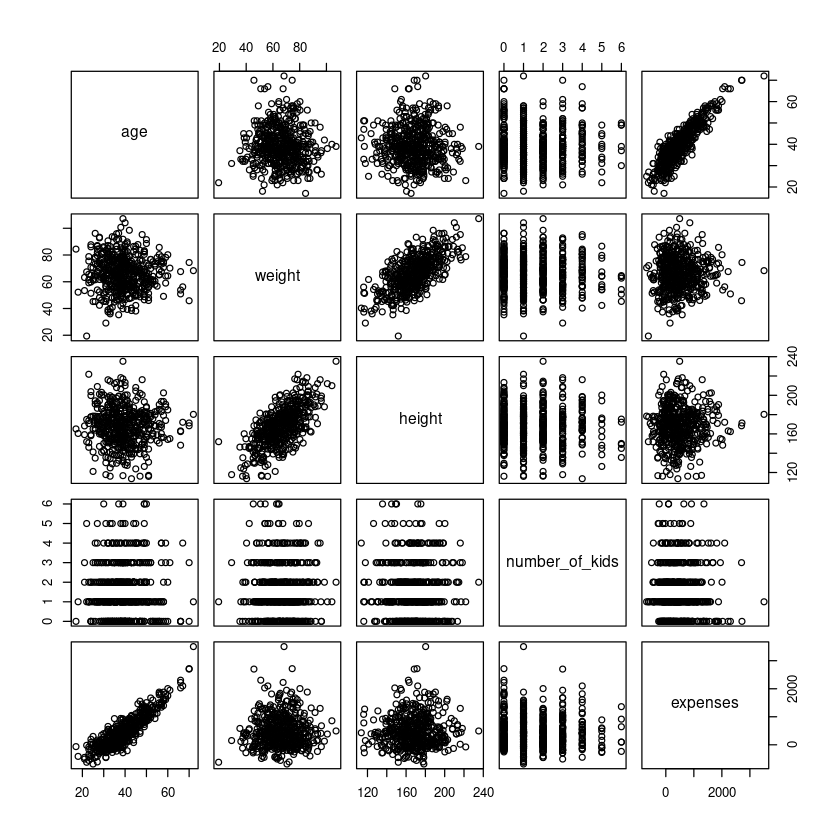

In [47]:
# Let's investigate variables correlaction.
pairs(df[quantitive])

As we can see, _height_ is positively correlated with _weight_, as well as _age_ is positively correlated with _expenses_. The second case is not harmful for our estimation, because _expenses_ is response variable - we can expect our regression model to have significant _age_ coefficient. 

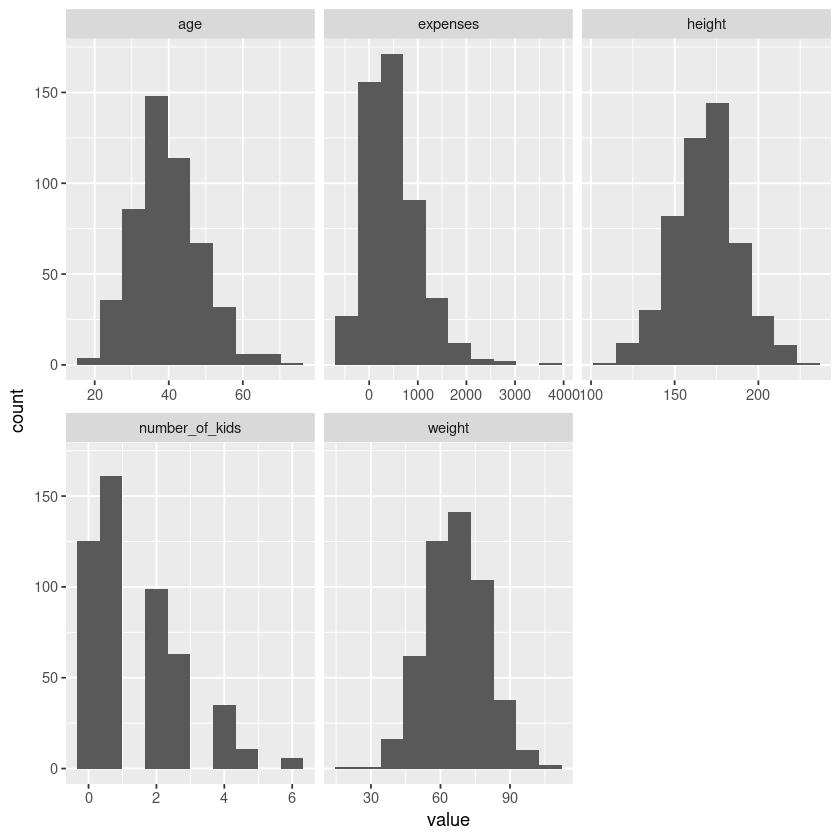

In [54]:
# Variables distributions, for having a complete insight into our data.

# https://stackoverflow.com/a/35373419
ggplot(gather(df[quantitive]), aes(value)) + 
    geom_histogram(bins = 10) + 
    facet_wrap(~key, scales = 'free_x')